In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = './data'

dataframe = pd.read_pickle(os.path.join(DATA_PATH, 'dataframe.pkl'))

In [3]:
"""
Let's print the head of the dataframe to Jupyter to check everything is okay!
"""

dataframe.head()

,document,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Exploration

In [ ]:
"""
We will do some basic exploration of the dataframe.

The goal of this example is to:

1. Demonstrate how to create a custom Keras text classification model.
2. Attempt to train this model in GCP and FloydHub (later!).

Exploration is therefore going to be quick and simple.
"""

In [4]:
"""
We have 1000 samples in the dataframe. There are no NULL values.
"""

dataframe.count()

document     1000
sentiment    1000
dtype: int64

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

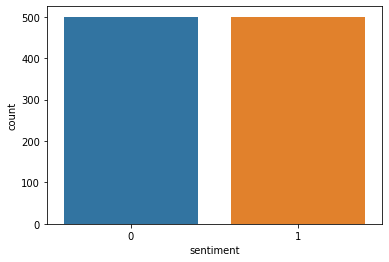

In [6]:
"""
The target variable (sentiment) is perfectly balanced between negative (0) samples and positive (1) samples.

Classification problems usually have some form of class imbalance (e.g. 1 class with more samples than another).

In the case of imbalance you may wish to oversample/undersample to create a more balanced class representation.

"""

sns.countplot(x='sentiment', data=dataframe)
plt.show()

### Splitting

In [7]:
import random
from sklearn.model_selection import train_test_split

RANDOM_STATE = 7

In [8]:
"""
Take the documents from our dataframe and assign them to X.
Take the sentiment from our dataframe and assign them to y.

The .values attribute returns a numpy array rather than a pandas series.
"""

X = dataframe['document'].values
y = dataframe['sentiment'].values

In [9]:
"""
Transform y from a single vector into a matrix more commonly used in Tensorflow.

Consider the vector [0, 1, 0, ... 0, 1, 0].

We transform this into a matrix:

[[1,0],
 [0,1],
 [1,0],
 ...,
 [1,0],
 [0,1],
 [1,0]]
"""

from keras.utils import np_utils

y = np_utils.to_categorical(y)

In [10]:
"""
We want to split our dataframe into a train set and a test set.

We will leave the test set to one side (we don't train on it!) so we can evaluate performance at the end.

We save 10% of our data for the test set (100 samples).

We also shuffle the data in case there is any ordering (e.g. all the negative samples at the end).
"""

random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=RANDOM_STATE)

In [11]:
"""
We split the train set further into a train set and a validation set.

The validation set will be used when we train the model to check its performance.
"""

random.seed(RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.1,
                                                  random_state=RANDOM_STATE)

In [12]:
"""
We can visually check that the splitting has worked by printing the shape of our resulting dataframes.

We can see that there is still a total of 1000 samples.
"""

X_train.shape, X_val.shape, X_test.shape

((810,), (90,), (100,))

### Preprocess

In [13]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [ ]:
"""
We're now going to do some preprocessing of the data.

We use Tensorflow's Tokenizer:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Consider the document "the cat SAT on the mat."

The default parameters of this Tokenizer do the following:

1. Split the document to a list -> ["the", "cat", "SAT", "on", "the", "mat", "."]
2. Remove punctuation from the texts -> ["the", "cat", "SAT", "on", "the", "mat"]
3. Convert the texts to lowercase -> ["the", "cat", "sat", "on", "the", "mat"]
4. Replace the strings with unique tokens -> [1, 2, 3, 4, 1, 5]
"""

In [14]:
tokenizer = Tokenizer()

In [15]:
tokenizer.fit_on_texts(X)

In [16]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [17]:
"""
Example of the Tokenizer conversion.
"""

print(X_train[0], X_train_tokens[0], sep='\n')

Perfect for the PS3.
[1693, 11, 1, 1694]


In [18]:
"""
We extract the length of our longest document.

When we pass our documents into the neural network - we require they are all the same size.

We will make all the documents the same length (i.e. the length of the longest document).
"""

max_document_len = max([len(doc.split()) for doc in X])

In [19]:
"""
We extract the number of words in our vocabulary (i.e. unique words across all documents).

This is another parameter we will pass into our neural network.
"""

vocab_size = len(tokenizer.word_index) + 1

In [20]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [21]:
"""
Tensorflow has a handy function to make all our documents the same length.

We make all the documents the length of max_document_len by padding them with zeros.

Consider tokenize("the cat sat on the mat.") -> [1, 2, 3, 4, 1, 5] with a max_document_len of 8:

We have an output of [1, 2, 3, 4, 1, 5, 0, 0]
"""

X_train_padded = pad_sequences(X_train_tokens, maxlen=max_document_len, padding='post')
X_val_padded = pad_sequences(X_val_tokens, maxlen=max_document_len, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_document_len, padding='post')

### Modelling

In [ ]:
"""
Now we're ready to start modelling.

We're going to make a custom neural network in Keras with the following layers:

1. Embedding Layer (transforms each word token into a vector).
2. LSTM Layer (a type of recurrent layer that will be trained on our documents).
3. Dense Layer (the output layer that contains two units [i.e. for our two classes])


For a great article on Embedding check out this link:

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
"""

In [23]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [24]:
"""
We implement EarlyStopping to prevent overfitting our model.

We specify that we want to monitor the accuracy of our model on the validation set.

If we don't see an improvement in 2 epochs (patience=2) we stop training the model.

We also include ModelCheckpoint which saves the best version of our model.

In this case we always save the version of the model that has the best accuracy on the validation set.
"""

MODEL_PATH = './models'

es = EarlyStopping(monitor='val_binary_accuracy', 
                   patience=2)
mc = ModelCheckpoint(os.path.join(MODEL_PATH, 'lstm_model.h5'),
                     monitor='val_binary_accuracy', 
                     save_best_only=True,
                     verbose=1)

cbs = [es, mc]

In [25]:
"""
We need to specify the dimension of the vectors for our Embedding Layer.

In this model we turn each word token into a vector of length 128.

We could find the optimal value for this hyperparameter by tuning the model.
"""

EMBEDDING_DIM = 128

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding

In [27]:
"""
This is a simple model with the structure we defined above.

The Embedding layer takes: vocab_size, EMBEDDING_DIM, max_document_len as arguments.

We also specify mask_zero=True to let the model know we have padded our input sequences with zeros (see Preprocess).

The LSTM layer is defined to have 64 units. We use a tanh activation function that is popular for LSTMs.

The Dense layer has 2 units (one per class) and we use a sigmoid activation function.
"""

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_document_len, mask_zero=True))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dense(2, activation='sigmoid'))

In [28]:
"""
Given we're using a sigmoid activation function - and we have a binary classification problem - we use binary crossentropy
as our loss function.
"""

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

In [29]:
history=model.fit(X_train_padded, 
                  y_train,
                  batch_size=32, 
                  epochs=30,
                  validation_data=(X_val_padded, y_val), 
                  verbose=True, 
                  callbacks=cbs)

Epoch 1/30
26/26 [==============================] - 5s 60ms/step - loss: 0.6913 - binary_accuracy: 0.5330 - val_loss: 0.6750 - val_binary_accuracy: 0.7222

Epoch 00001: val_binary_accuracy improved from -inf to 0.72222, saving model to ./models\lstm_model.h5
Epoch 2/30
26/26 [==============================] - 0s 11ms/step - loss: 0.6136 - binary_accuracy: 0.8604 - val_loss: 0.7337 - val_binary_accuracy: 0.7111

Epoch 00002: val_binary_accuracy did not improve from 0.72222
Epoch 3/30
26/26 [==============================] - 0s 11ms/step - loss: 0.3858 - binary_accuracy: 0.9204 - val_loss: 0.4638 - val_binary_accuracy: 0.7889

Epoch 00003: val_binary_accuracy improved from 0.72222 to 0.78889, saving model to ./models\lstm_model.h5
Epoch 4/30
26/26 [==============================] - 0s 11ms/step - loss: 0.1965 - binary_accuracy: 0.9627 - val_loss: 0.4634 - val_binary_accuracy: 0.8444

Epoch 00004: val_binary_accuracy improved from 0.78889 to 0.84444, saving model to ./models\lstm_model.h5

In [30]:
from keras.models import load_model

In [31]:
"""
We could simply use the model object we have trained in this notebook.

However I'm going to show you how to load a saved model here.
"""

saved_model = load_model(os.path.join(MODEL_PATH, 'lstm_model.h5'))

In [32]:
saved_model.evaluate(X_test_padded, y_test)

4/4 [==============================] - 1s 0s/step - loss: 0.6595 - binary_accuracy: 0.8200


[0.6595014929771423, 0.8199999928474426]

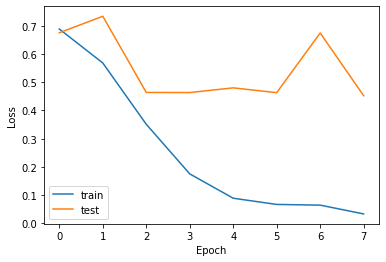

In [33]:
"""
Using the history object we created during model.fit() we can plot the loss of the network over the Epochs.
"""

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

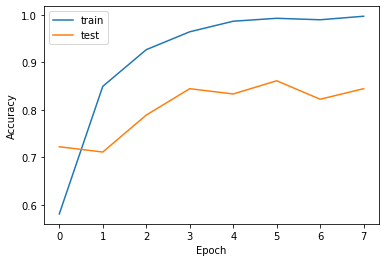

In [34]:
"""
We can also plot the accuracy of the network over the Epochs.
"""

plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import classification_report

In [36]:
"""
We can make predictions for our test set by calling saved_model.predict().
"""

predictions = saved_model.predict(X_test_padded)

In [37]:
"""
We can then use classification_report from sklearn.metrics to get a report on our models performance.

We can see pretty good performance on the test set, with an accuracy of 81%.

Not bad for only 1000 reviews and a model with no tuning (and only 1 LSTM layer!).

The random initialisation of weights of the neural network appears to have a big impact on this problem. Previous runs of the
same code block were able to achieve upwards of 84% accuracy.
"""

print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        49
           1       0.86      0.75      0.80        51

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

